# **Using Physical Attributes and Point Percentages to Predict Position for NBA Players**

##### *Tanisha Amrin, Charmaine Chui, Jakob Sereda, Julian Wright*

## **Introduction**

One of the most popular sports in North America and worldwide (*SportsPro Media*, 2023), basketball has been played by millions, both professional and amateur, since its invention in 1891 (*National Geographic*, 2021). When it comes to professional basketball, all eyes are on the National Basketball Association (or NBA), considered to be the premier professional basketball league in the world (*SportsPro Media*, 2023). 

A key aspect of basketball are the positions of the players. The nuances of these roles can have a profound impact on a team's ability to perform, allowing individual players to show their unique talents if placed in the right role (*RedBull*, 2022). Our goal is to produce a data-driven tool to help categorize players into a position that best suits their body type and skillset.

The question we seek to answer is: **What position is an NBA player most likely to play, given their height, weight, free-throw percentage, and field goal percentage?**

The data set we will use to answer this question was pulled from [*nba.com*](https://www.nba.com/stats/players), the official website of the NBA (*NBA API Client Package, see bibliography*). It contains stats on individual players during each NBA season. There are 58 columns and 4,917 rows in this data set, missing values are represented by "NA". 

## **Preliminary Exploratory Data Analysis**

In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(RColorBrewer)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
set.seed(2024) 

# reading in the data from the web
nba_data <- read_csv("https://raw.githubusercontent.com/jakobsereda/dsci-100-project/main/data/stats.csv", show_col_types = FALSE) 

# cleaning and wrangling the data
names(nba_data) <- tolower(names(nba_data))

nba_clean <- nba_data |>
    select(person_id, first_name, last_name, height, weight, position, season_id, 
           gp, gs, min, fg_pct, fg3_pct, ft_pct, reb, ast, stl, blk, tov, pf, pts) |>
    na.omit() |>
    mutate(position = ifelse(position == "Center-Forward", "Center", position)) |>
    mutate(position = ifelse(position == "Guard-Forward", "Guard", position)) |>
    mutate(position = ifelse(position == "Forward-Guard" | position == "Forward-Center", "Forward", position)) |>
    mutate(position = as_factor(position))

# splitting the data into training and testing sets
nba_split <- initial_split(nba_clean, prop = 3/4, strata = position)

nba_train <- training(nba_split)
nba_test <- testing(nba_split)

head(nba_train)

ERROR: Error in open.connection(structure(4L, class = c("curl", "connection"), conn_id = <pointer: 0x392>), : HTTP error 404.


In [110]:
# summarizing the number of players in each position, and the min, max, and mean of each predictor for each position
nba_summarized <- nba_train |>
    group_by(position) |>
    summarize(min_height = min(height), max_height = max(height), mean_height = mean(height),
              min_weight = min(weight), max_weight = max(weight), mean_weight = mean(weight),
              min_fg_pct = min(fg_pct), max_fg_pct = max(fg_pct), mean_fg_pct = mean(fg_pct),
              min_ft_pct = min(ft_pct), max_ft_pct = max(ft_pct), mean_ft_pct = mean(ft_pct),
              n_players = n())

nba_summarized

position,min_height,max_height,mean_height,min_weight,max_weight,mean_weight,min_fg_pct,max_fg_pct,mean_fg_pct,min_ft_pct,max_ft_pct,mean_ft_pct,n_players
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Forward,71,86,80.11799,153,289,226.2340,0,1,0.4092183,0,1,0.6031200,1017
Center,79,91,83.36118,195,360,250.5577,0,1,0.4317838,0,1,0.5567199,407
Guard,65,84,75.56789,133,255,194.8569,0,1,0.3732541,0,1,0.6561018,1090


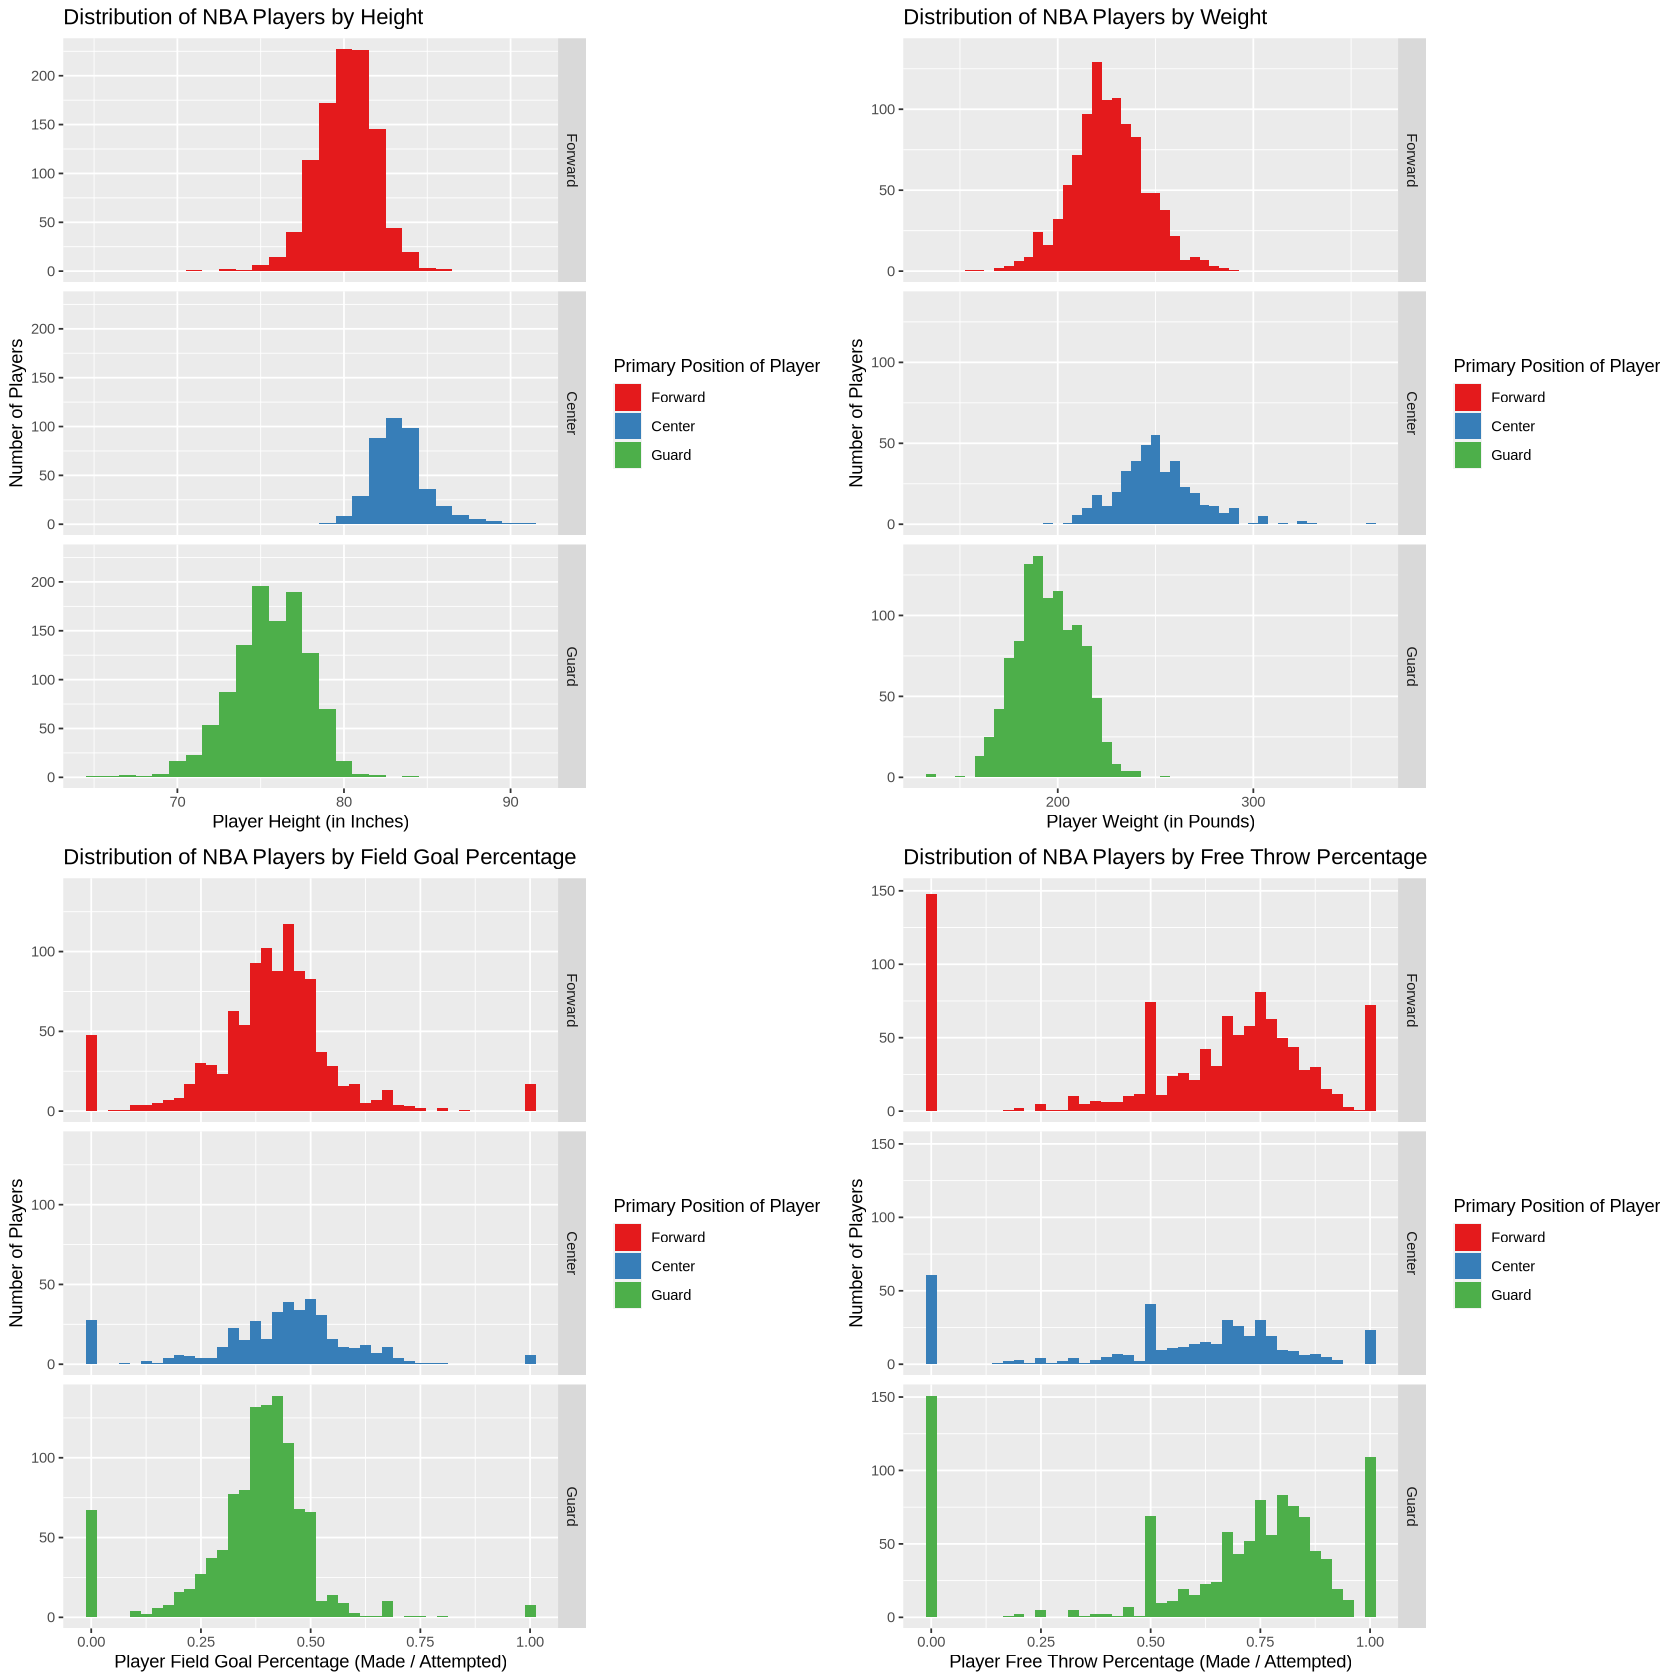

In [112]:
options(repr.plot.width = 14, repr.plot.height = 14)

# plotting the distributions of all predictors for each position (using training data)
nba_plot_height <- nba_train |>
    ggplot(aes(x = height, fill = position)) +
        geom_histogram(binwidth = 1) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Height (in Inches)", y = "Number of Players", 
             fill = "Primary Position of Player", title = "Distribution of NBA Players by Height") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_weight <- nba_train |>
    ggplot(aes(x = weight, fill = position)) +
        geom_histogram(binwidth = 5) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Weight (in Pounds)", y = "Number of Players", 
             fill = "Primary Position of Player", title = "Distribution of NBA Players by Weight") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_fg_pct <- nba_train |>
    ggplot(aes(x = fg_pct, fill = position)) +
        geom_histogram(binwidth = 0.025) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Field Goal Percentage (Made / Attempted)", y = "Number of Players", 
             fill = "Primary Position of Player", title = "Distribution of NBA Players by Field Goal Percentage") +
        scale_fill_brewer(palette = 'Set1')

nba_plot_ft_pct <- nba_train |>
    ggplot(aes(x = ft_pct, fill = position)) +
        geom_histogram(binwidth = 0.025) +
        facet_grid(rows = vars(position)) +
        labs(x = "Player Free Throw Percentage (Made / Attempted)", y = "Number of Players", 
             fill = "Primary Position of Player", title = "Distribution of NBA Players by Free Throw Percentage") +
        scale_fill_brewer(palette = 'Set1')

grid.arrange(nba_plot_height, nba_plot_weight, nba_plot_fg_pct, nba_plot_ft_pct, ncol = 2)

## **Methods**

The raw data was large and difficult to read, so we began by transforming it into a cleaner format. We then mutated the data such that each player was labeled by their *primary position*. The variables we chose to analyze with respect to **position** were:
- **HEIGHT:** player's height in inches
- **WEIGHT:** player's weight in lbs
- **FG_PCT:** field goal percentage (field goals made / field goals attempted)
- **FT_PCT:** free throw percentage (free throws made / free throws attempted)

To visualize our results, we created histograms displaying the distribution of **height**, **weight**, **fg_pct**, and **ft_pct** for each **position**. We observed different curves for both **height** and **weight** depending on **position**, confirming that they are good predictors. Additionally, we recognized some very slight, and surprisingly small differences for both **fg_pct** and **ft_pct**.

Ultimately, we decided to make **height**, **weight**, **fg_pct**, and **ft_pct** our predictors for **position**. We also decided that we would use these predictors to create a **k-nn** model.

## **Expected Outcome and Significance**

We expect to find that:
- Players classified as **Centers** will, on average, tend to be taller, weigh more, have higher field goal percentages, and lower free throw percentages
- Players classified as **Guards** will, on average, tend to be shorter, weigh less, have lower field goal percentages, and higher free throw percentages
- Players classified as **Forwards** will, on average, tend to split the difference between the observed stats for Centers and Guards

These findings could be beneficial in managing a lineup for NBA teams. They will allow managers to maximize the overall performance of the team through positioning. 

Subsequent questions this analysis could lead to:
- Whether team performance relies on hard stats or player chemistry- Which variables most strongly influence position prediction 


## **Bibliography**

- Data is pulled from [*nba.com*](https://www.nba.com/stats/players), the official website of the NBA, 
   using the NBA API Client package; [*github.com/swar/nba_api*](https://github.com/swar/nba_api) (Swar Patel, Randall Forbes, et al). *Note: this dataset was not provided on Canvas, but was approved by a TA during tutorial.*
- McMurray, Ben. "Why the NBA is America's Most Globally Relevant Sports Property." *SportsPro Media*, 24 Oct. 2023, [*link*](https://www.sportspromedia.com/insights/analysis/nba-tv-rights-revenue-global-popularity-data-ampere-analysis/).
- Toole, T.C. "Here's the History of Basketball - From Peach Baskets in Springfield to Global Phenomenon." *National Geographic*, 27 Mar. 2021, [*link*](https://www.nationalgeographic.com/history/article/basketball-only-major-sport-invented-united-states-how-it-was-created).
- Lister, Aimee. "Basketball Positions Explained: What Each Player Does." *RedBull*, 21 Jul. 2022, [*link*](https://www.redbull.com/us-en/basketball-positions-what-each-player-does#:~:text=Generally%20speaking%2C%20each%20team%20is,handling%2C%20passing%20and%20shooting%20skills.).